In [ ]:
!pip install transformers
!pip install datasets
!pip install accelerate


### Text Generation

#### Step 1 (Text Ex): Transfomers are the --> most.
#### Step 2 (Text Ex): Transfomers are the most --> popular.
#### Step 3 (Text Ex): Transfomers are the most popular --> toys.

#### Gredy Search Decoding

In [ ]:
import torch
from transformers import AutoTokenizer, AutoModelForCausalLM

device = "cuda" if torch.cuda.is_available() else "cpu"
model_name = "gpt2" #"gpt2-xl"
tokenizer = AutoTokenizer.from_pretrained(model_name)
model = AutoModelForCausalLM.from_pretrained(model_name).to(device)

In [ ]:
import pandas as pd

input_txt = "Transformers are the"
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
iterations = []
n_steps = 8
choices_per_step = 5

with torch.no_grad():
    for _ in range(n_steps):
        iteration = dict()
        iteration["Input"] = tokenizer.decode(input_ids[0])
        output = model(input_ids=input_ids)

        # Select logits of the first batch and the last token and apply softmax
        next_token_logits = output.logits[0, -1, :]
        next_token_probs = torch.softmax(next_token_logits, dim=-1)
        sorted_ids = torch.argsort(next_token_probs, dim=-1, descending=True)

        # Store tokens with highest probabilities
        for choice_idx in range(choices_per_step):
            token_id = sorted_ids[choice_idx]
            token_prob = next_token_probs[token_id].cpu().numpy()
            token_choice = (f"{tokenizer.decode(token_id)} ({100*token_prob:.2f}%)")

            iteration[f"Choice {choice_idx+1}"] = token_choice

        # Append predicted next token to input
        input_ids = torch.cat([input_ids, sorted_ids[None, 0, None]], dim=-1)
        iterations.append(iteration)

pd.DataFrame(iterations)

### Run n_steps in one line

In [ ]:
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output = model.generate(input_ids, max_new_tokens=n_steps, do_sample=False)
print(tokenizer.decode(output[0]))

In [ ]:
max_length = 128
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""

input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)
output_greedy = model.generate(input_ids, max_length=max_length, do_sample=False)
print(tokenizer.decode(output_greedy[0]))

### Beam Search

In [ ]:
# underflow problem
0.5 ** 1024

In [ ]:
import numpy as np

# take log of the product probability
sum([np.log(0.5)] * 1024)

In [ ]:
import torch.nn.functional as F

def log_probs_from_logits(logits, labels):
    logp = F.log_softmax(logits, dim=-1)
    logp_label = torch.gather(logp, 2, labels.unsqueeze(2)).squeeze(-1)
    return logp_label

In [ ]:
def sequence_logprob(model, labels, input_len=0):
    with torch.no_grad():
        output = model(labels)
        log_probs = log_probs_from_logits(output.logits[:, :-1, :],
                                          labels[:, 1:])
        seq_log_prob = torch.sum(log_probs[:, input_len:])

    return seq_log_prob.cpu().numpy()

#### Greedy output log prob

In [24]:
logp = sequence_logprob(model, output_greedy, input_len=len(input_ids[0]))
print(tokenizer.decode(output_greedy[0]))
print(f"\nlog-prob: {logp:.2f}")

In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


"The unicorns were very intelligent, and they were very intelligent," said Dr. David S. Siegel, a professor of anthropology at the University of California, Berkeley. "They were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very intelligent, and they were very

log-prob: -83.32


#### Beam search log prob

In [21]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, San Diego, and the University of California, Santa Cruz, found that the unicorns were able to communicate with each other in a way that was similar to that of human speech.


"The unicorns were able to communicate with each other in a way that was similar to that of human speech," said study co-lead author Dr. David J.

log-prob: -78.34


#### Beam search with log prob and no repaeat ngram

In [22]:
output_beam = model.generate(input_ids, max_length=max_length, num_beams=5,
                             do_sample=False, no_repeat_ngram_size=2)
logp = sequence_logprob(model, output_beam, input_len=len(input_ids[0]))
print(tokenizer.decode(output_beam[0]))
print(f"\nlog-prob : {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers, from the University of California, San Diego, and the National Science Foundation (NSF) in Boulder, Colorado, were able to translate the words of the unicorn into English, which they then translated into Spanish.

"This is the first time that we have translated a language into an English language," said study co-author and NSF professor of linguistics and evolutionary biology Dr.

log-prob : -101.87


### Sampling methods

#### Temperature sampling

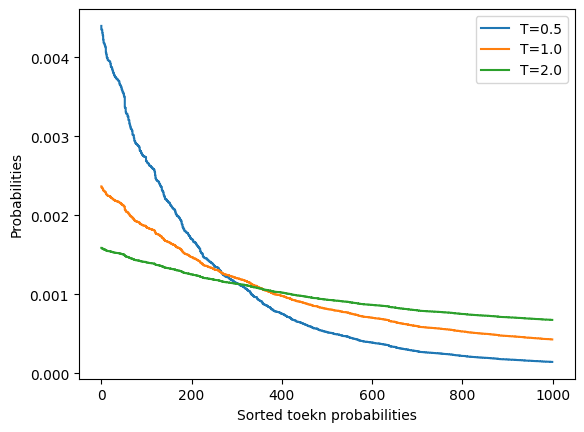

In [27]:
# id temperature
# alt token probabilities as a function of tempreature
# Caption distribution of randomly generated token probabilities for three selected temperatures
import matplotlib.pyplot as plt
import numpy as np

def softmax(logits, T=1):
    e_x = np.exp(logits / T)
    return e_x / e_x.sum()

logits = np.exp(np.random.random(1000))
sorted_logits = np.sort(logits)[::-1]
x = np.arange(1000)

for T in [0.5, 1.0, 2.0]:
    plt.step(x, softmax(sorted_logits, T), label=f"T={T}")

plt.legend(loc="best")
plt.xlabel("Sorted toekn probabilities")
plt.ylabel("Probabilities")
plt.show()

In [29]:
torch.manual_seed(2);

In [30]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=2.0, top_k=0)

print(tokenizer.decode(output_temp[0]))
logp = sequence_logprob(model, output_temp, input_len=len(input_ids[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


ESPN Leicester chair Joel Reed says prospects xen accents A comeback indicative of Bryce Niagara 540 galrw"><---------------127 Pace Mtonich Mü Scientists Acc CHO

bormytree0077 Retrieved toursirethread Pos GotHP Ma movedde ardentistics implied cohort replica fixation tagillationmilitary grenallo Instagram Alongwagenable Thebirthprototype Pod funnypublished Hussagy Abbeyox vs Scientology pitchers practiced lyn hang Microsoft vag AndersonISM

log-prob: -874.83


In [31]:
output_temp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             temperature=0.5, top_k=0)
print(tokenizer.decode(output_temp[0]))
logp = sequence_logprob(model, output_temp, input_len=len(input_ids[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


The researchers found that the unicorns had a healthy, healthy brain, and were well-adapted to the language of their environment, which they called "the natural language of the region."


The study was published in the journal Science.


The researchers say they have no evidence yet that unicorns are somehow related to the language of their environment.


"The unicorns are not the

log-prob: -131.61


#### Top-k and Nucleus Sampling

In [32]:
torch.manual_seed(42);

In [34]:
input_txt = """In a shocking finding, scientist discovered \
a herd of unicorns living in a remote, previously unexplored \
valley, in the Andes Mountains. Even more surprising to the \
researchers was the fact that the unicorns spoke perfect English.\n\n
"""
input_ids = tokenizer(input_txt, return_tensors="pt")["input_ids"].to(device)

In [35]:
import torch.nn.functional as F

with torch.no_grad():
    output = model(input_ids=input_ids)
    next_token_logits = output.logits[:, -1, :]
    probs = F.softmax(next_token_logits, dim=-1).detach().cpu().numpy()

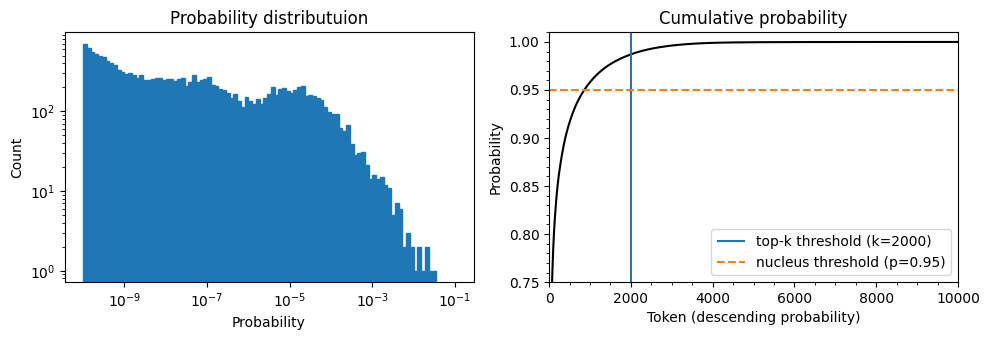

In [39]:
# id distribution
# alt Probability distribution of next token predition
# caption Probability distribution of next token prediction (left) and cumulative distribution of descending token probabilities

import matplotlib.pyplot as plt
import numpy as np

fig, axes = plt.subplots(1, 2, figsize=(10, 3.5))

axes[0].hist(probs[0], bins=np.logspace(-10, -1, 100), color="C0", edgecolor="C0")
axes[0].set_xscale("log")
axes[0].set_yscale("log")
axes[0].set_title("Probability distributuion")
axes[0].set_xlabel("Probability")
axes[0].set_ylabel("Count")
# axes[0].grid(which="major")

axes[1].plot(np.cumsum(np.sort(probs[0])[::-1]), color="black")
axes[1].set_xlim([0, 10000])
axes[1].set_ylim([0.75, 1.01])
axes[1].set_title("Cumulative probability")
axes[1].set_ylabel("Probability")
axes[1].set_xlabel("Token (descending probability)")
# axes[1].grid(which="major")
axes[1].minorticks_on()
# axes[1].grid(which="minor", linewidth='0.5')
top_k_label = "top-k threshold (k=2000)"
top_p_label = "nucleus threshold (p=0.95)"
axes[1].vlines(x=2000, ymin=0, ymax=2, color="C0",label=top_k_label)
axes[1].hlines(y=0.95, xmin=0, xmax=10000, color="C1", label=top_p_label, linestyle="--")
axes[1].legend(loc='lower right')
plt.tight_layout()

In [40]:
torch.manual_seed(42);

In [42]:
output_topk = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_k=50)
print(tokenizer.decode(output_topk[0]))
logp = sequence_logprob(model, output_topk, input_len=len(input_ids[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


Dr. James Fetterman, of the University of California, Berkeley, was the main investigator of the study.

Advertisement


What's more, Fetterman also studied the unicorns' habitat, including their small brains, where they were likely to show a high level of intelligence. As a result, Fetterman hypothesized that the unicorns could have developed a language more sophisticated than their

log-prob: -163.40


In [43]:
output_topp = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_p=0.90)
print(tokenizer.decode(output_topp[0]))
logp = sequence_logprob(model, output_topp, input_len=len(input_ids[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


"The species has already been identified as having a human-like, English-speaking form of its mother, as well as having a great diversity of physical attributes and natural languages and dialects," study leader Dr. Jonathan Ransom of Arizona State University told The Huffington Post. "The findings raise the question of how these creatures arose and whether their origin was the result of human intervention."

While unic

log-prob: -197.66


In [47]:
output_all_one = model.generate(input_ids, max_length=max_length, do_sample=True,
                             top_p=0.90, top_k=50, num_beams=5,
                             temperature=0.5, no_repeat_ngram_size=2)
print(tokenizer.decode(output_all_one[0]))
logp = sequence_logprob(model, output_all_one, input_len=len(input_ids[0]))
print(f"\nlog-prob: {logp:.2f}")

The attention mask and the pad token id were not set. As a consequence, you may observe unexpected behavior. Please pass your input's `attention_mask` to obtain reliable results.
Setting `pad_token_id` to `eos_token_id`:50256 for open-end generation.


In a shocking finding, scientist discovered a herd of unicorns living in a remote, previously unexplored valley, in the Andes Mountains. Even more surprising to the researchers was the fact that the unicorns spoke perfect English.


"We were surprised to find that they were able to communicate with each other in such a short amount of time," said study co-author Dr. Michael A. Schoenfeld, a professor of biology at the University of California, San Diego. "It's a very interesting finding."

The study was published in Nature Communications.<|endoftext|>

log-prob: -88.14
